<a href="https://colab.research.google.com/github/yurigalindo/PyTorchSamples/blob/main/Colab%20Notebooks/CLIP_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lw06tol6
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-lw06tol6
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=ff8a7dcf6dabf17ff3cc13f2991176800369b0a3468620621c5dafd76724ae63
  Stored in directory: /tmp/pip-ephem-wheel-cache-6bxtc_6h/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=315c805de308c51312f666805b6d924c782a7487a4ef25317525bebb9ae59aa3
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


In [ ]:
from typing import Callable, List, Type

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.datasets import CIFAR10
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, InterpolationMode
  
BICUBIC = InterpolationMode.BICUBIC
device = "cuda" if torch.cuda.is_available() else "cpu"
cifar10 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False,transform=Compose([ToTensor()]))

class CLIP(nn.Module):
    def __init__(self):
        super(CLIP, self).__init__()
        self.clip, self.preprocess = clip.load('ViT-B/32', device)
        self.text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar10.classes]).to(device)
        self.preprocess = Compose([
        Resize(224, interpolation=BICUBIC),
        CenterCrop(224),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
        print("Encoding texts")
        print(self.text_inputs)
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return self.clip(self.preprocess(image).to(device),self.text_inputs)[0]

Files already downloaded and verified


In [ ]:
!pip install robustness

     |████████████████████████████████| 95 kB 2.5 MB/s 
     |████████████████████████████████| 180 kB 38.8 MB/s 
     |████████████████████████████████| 124 kB 47.0 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=ac03a7747562fc06668c672aadde97dca68e2e2f91fc81e80d45060d665719a0
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [ ]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
#from torch.utils.model_zoo import load_url as load_state_dict_from_url
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT

DATA_PATH_DICT = {
    'CIFAR': '/tmp/',
    'RestrictedImageNet': '/scratch/engstrom_scratch/imagenet',
    'ImageNet': '/scratch/engstrom_scratch/imagenet',
    'H2Z': '/scratch/datasets/A2B/horse2zebra',
    'A2O': '/scratch/datasets/A2B/apple2orange',
    'S2W': '/scratch/datasets/A2B/summer2winter_yosemite'
}

%matplotlib inline

In [ ]:
# Constants
DATA = 'CIFAR' # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
BATCH_SIZE = 10
NUM_WORKERS = 2
NUM_CLASSES_VIS = 10

# DATA_SHAPE = 32 if DATA == 'CIFAR' else 224 # Image size (fixed for dataset)
DATA_SHAPE=224
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA] # Class names for dataset
NUM_CLASSES = len(CLASSES) - 1 
NUM_CLASSES_VIS = min(NUM_CLASSES_VIS, NUM_CLASSES)
# GRAIN = 4 if DATA != 'CIFAR' else 1
GRAIN = 4

In [ ]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Load model
clip_inst = CLIP()
# model_kwargs = {
#     'arch': 'resnet50',
#     'dataset': dataset,
# }

model_kwargs = {
    'arch': clip_inst,
    'dataset': dataset,
    'add_custom_forward': True
}
model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()

Encoding texts
tensor([[49406,   320,  1125,   539,   320, 16451, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320,  1125,   539,   320, 25258, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,

AttackerModel(
  (normalizer): InputNormalize()
  (model): DummyModel(
    (model): CLIP(
      (clip): CLIP(
        (visual): VisionTransformer(
          (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (transformer): Transformer(
            (resblocks): Sequential(
              (0): ResidualAttentionBlock(
                (attn): MultiheadAttention(
                  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                )
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (mlp): Sequential(
                  (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                  (gelu): QuickGELU()
                  (c_proj): Linear(in_features=3072, out_features=768, bias=True)
                )
                (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=Tru

In [ ]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

In [ ]:
# Get seed distribution (can be memory intensive to do all ImageNet classes at once)

im_test, targ_test = [], []
#im_test must be from the same size of desired image generation
for _, (im, targ) in enumerate(test_loader):
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = ch.cat(im_test), ch.cat(targ_test)

conditionals = []
for i in tqdm(range(NUM_CLASSES_VIS)):
    imc = im_test[targ_test == i]
    down_flat = downsample(imc).view(len(imc), -1)
    mean = down_flat.mean(dim=0)
    down_flat = down_flat - mean.unsqueeze(dim=0)
    cov = down_flat.t() @ down_flat / len(imc)
    dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
    conditionals.append(dist)

  0%|          | 0/10 [00:03<?, ?it/s]


ValueError: ignored

In [ ]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(NUM_CLASSES_VIS)])
img_seed = ch.clamp(img_seed, min=0, max=1)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(NUM_CLASSES_VIS)]])

IndexError: ignored

In [ ]:
def generation_loss(mod, inp, targ):
    op = mod(inp)
    loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
    return loss, None

kwargs = {
        'custom_loss': generation_loss,
        'constraint':'2',
        'eps': 40,
        'step_size': 1,
        'iterations': 60,
        'targeted': True,
}  
    
if DATA == 'CIFAR':
    kwargs['eps'] = 30
    kwargs['step_size'] = 0.5
    kwargs['iterations'] = 60

In [ ]:
show_seed = False
model = model.cuda()
for i in range(NUM_CLASSES_VIS):
    target_class = i * ch.ones((BATCH_SIZE, )) 
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed.cuda(), target_class.long().cuda(), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   [CLASSES[int(t)].split(',')[0] for t in target_class], 
                   fontsize=18)

RuntimeError: ignored

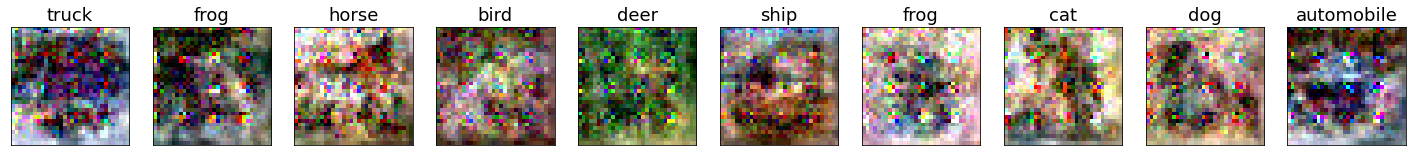

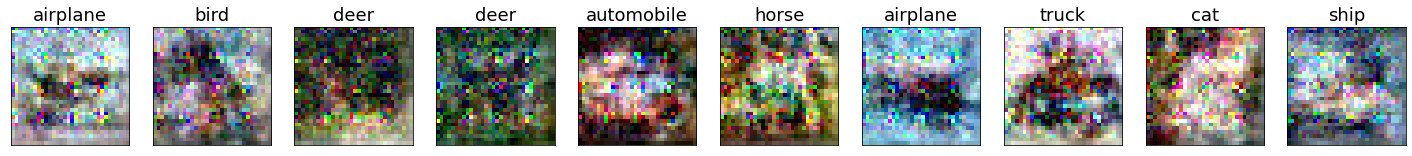

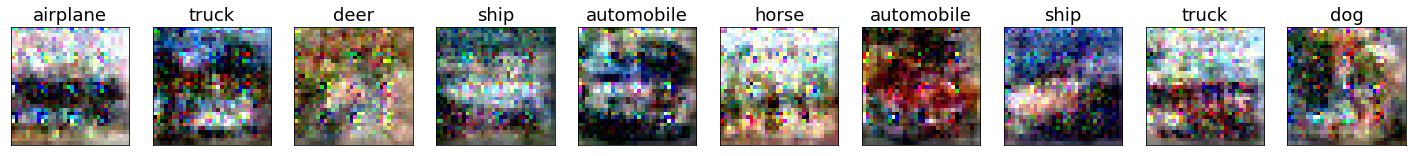

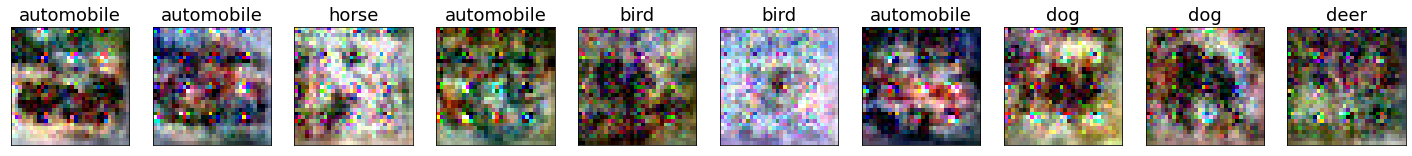

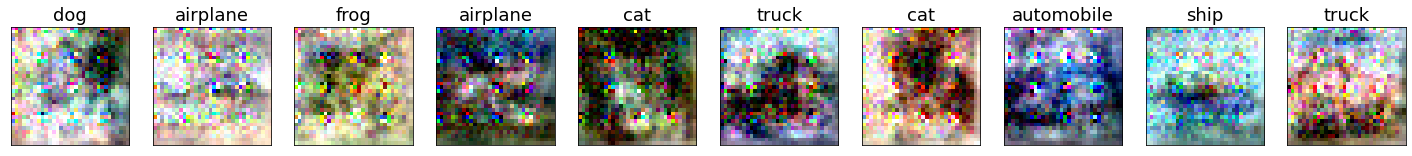

In [ ]:
show_seed = False
for i in range(5):
    target_class = ch.tensor(np.random.choice(range(NUM_CLASSES_VIS), (BATCH_SIZE,)))
    im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                        for t in target_class])
    
    im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
    _, im_gen = model(im_seed.cuda(), target_class.long().cuda(), make_adv=True, **kwargs)
    if show_seed:
        show_image_row([im_seed.cpu()], [f'Seed ($x_0$)'], fontsize=18)
    show_image_row([im_gen.detach().cpu()], 
                   tlist=[[CLASSES[int(t)].split(',')[0] for t in target_class]], 
                   fontsize=18)